In [ ]:
'''
Description:

This project utilizes a dataset from the titanic to predict whether or not someone has survived.  This is employed using a classification model.
It features data engineering to quantify certain values, and drop columns that likely are not needed for the prediciton.  The Stochastic
Gradient Descent classifier is used to handle the predictions.  At the end, calculations for Precision, Recall, the Confusion Matrix are included,
along with a ROC Curve calculation and graph.

The dataset was taken from the UCI Machine Learning Repository.
'''

In [239]:
#This cell helps to configure the project, such as importing required libraries, and defining a function to save graphs

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [241]:
#This cell imports the CSV file
import pandas as pd

def load_data():
    return pd.read_csv("titanic.csv")

In [243]:
#This cell assigns a variable to the csv file, and then takes a look at the head of the file (first 5 entries)
titanic = load_data()
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [244]:
#This cell takes a closer look at the dataset as a whole, checking for null values
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [247]:
#This cell handles the data engineering for the dataset
import random

#Dropping columns that don't make sense to be used and/or have null values
if 'Cabin' in titanic.columns:
    titanic.drop('Cabin', axis=1, inplace=True)

if 'PassengerId' in titanic.columns:
    titanic.drop('PassengerId', axis=1, inplace=True)

if 'Name' in titanic.columns:
    titanic.drop('Name', axis=1, inplace=True)

if 'Ticket' in titanic.columns:
    titanic.drop('Ticket', axis=1, inplace=True)

if 'Embarked' in titanic.columns:
    titanic.drop('Embarked', axis=1, inplace=True)

#Setting null values for Age column to a random number between 0 and max age
max_age = titanic['Age'].max()  # Use a different variable name
titanic['Age'] = titanic['Age'].apply(lambda x: random.uniform(0, max_age) if pd.isna(x) else x)

#Mapping sex to numeric values
sex_mapping = {
    'female': 0,
    'male': 1
}
titanic['Sex'] = titanic['Sex'].map(sex_mapping)


#Checking the information after data engineering
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


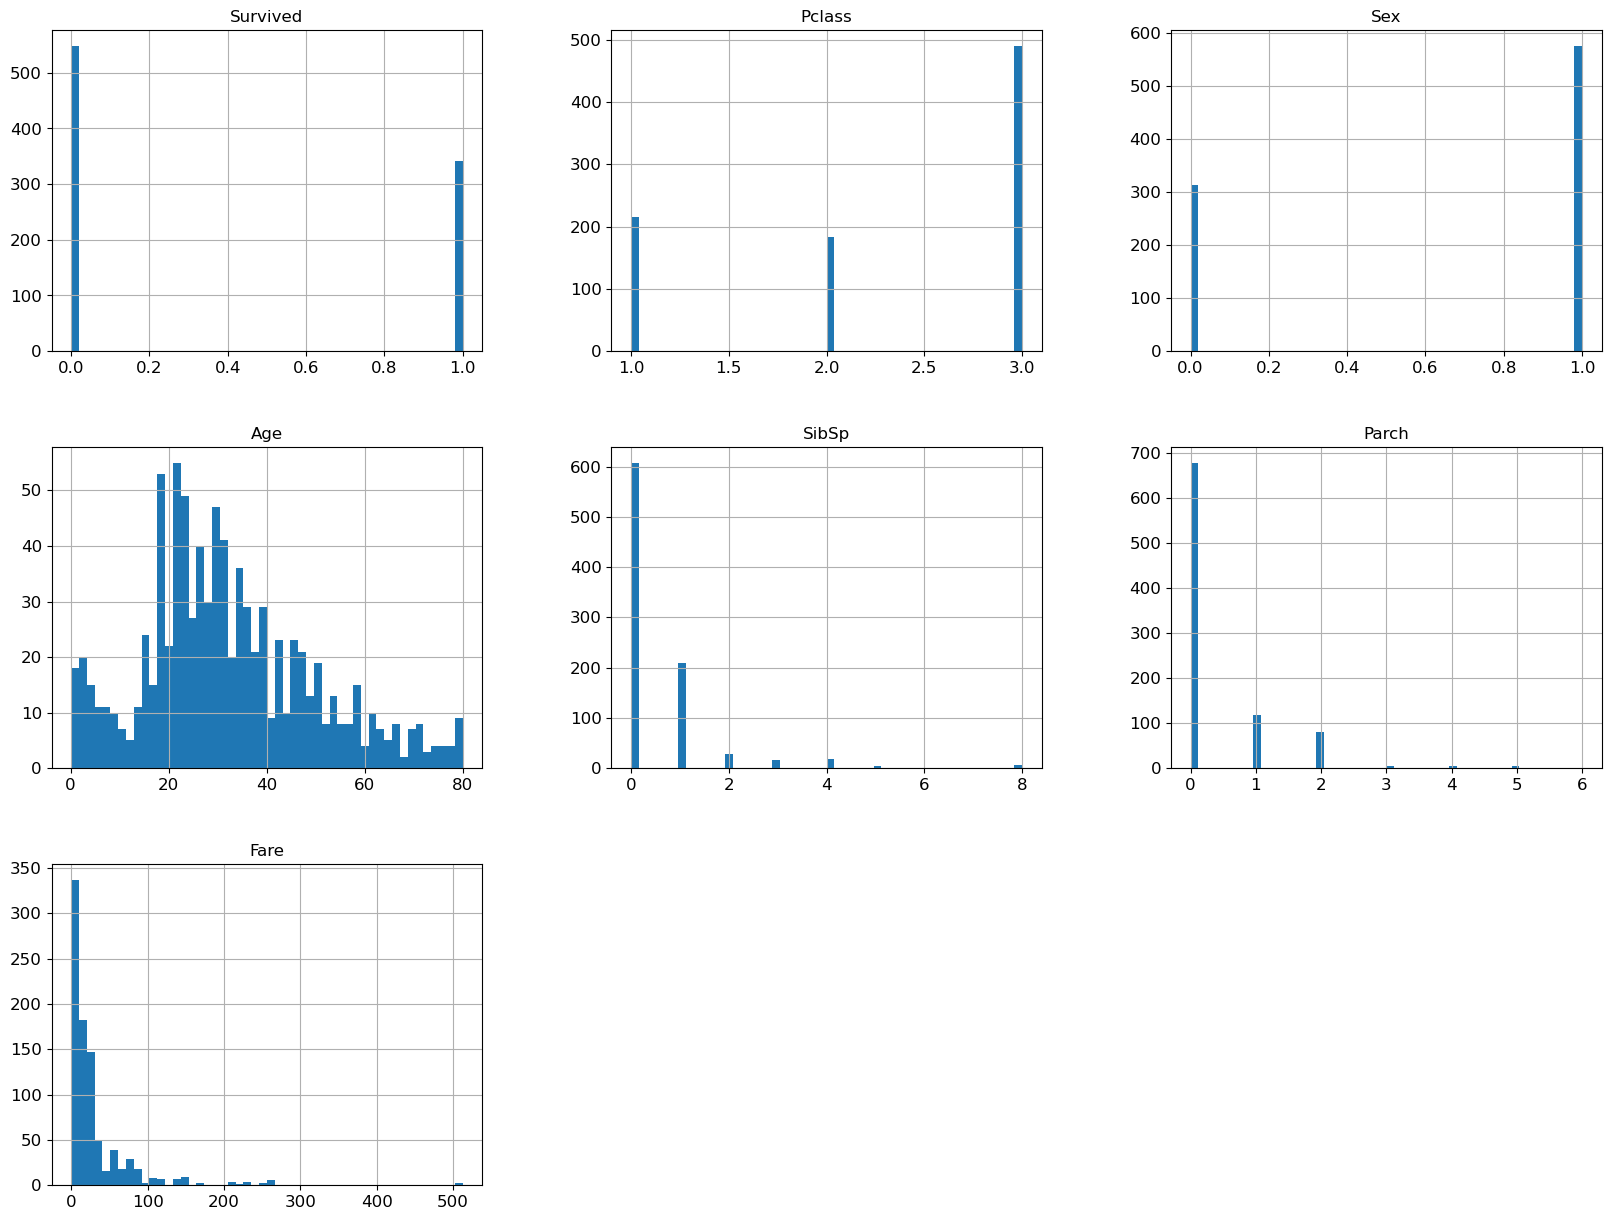

In [248]:
#This cell creates a histogram to view the columns of the dataframe
%matplotlib inline
import matplotlib.pyplot as plt
titanic.hist(bins=50, figsize=(20,15))
plt.show()

In [250]:
#This cell prepares the data for training
titanic_train = titanic.drop(columns=['Survived'])
x_train_survived = titanic['Survived']

some_person = titanic_train.iloc[0]
#addressing error found while predicting)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
some_person_df = pd.DataFrame([some_person], columns=features)
print(some_person_df)

   Pclass  Sex   Age  SibSp  Parch  Fare
0     3.0  1.0  22.0    1.0    0.0  7.25


In [251]:
#This cell splits the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(titanic_train, x_train_survived, test_size=0.2, random_state=42)


In [252]:
#This cell trains the classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [253]:
#This cell tests the prediction
sgd_clf.predict(some_person_df)

array([0], dtype=int64)

In [254]:
#This cell handles creation of the confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[257, 187],
       [110, 158]], dtype=int64)

In [255]:
#This cell calculates precision
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred)

0.4579710144927536

In [256]:
#This cell calculates recall
recall_score(y_train, y_train_pred)

0.5895522388059702

In [257]:
#This cell calculates the ROC Curve
from sklearn.metrics import roc_curve
y_scores = sgd_clf.decision_function(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

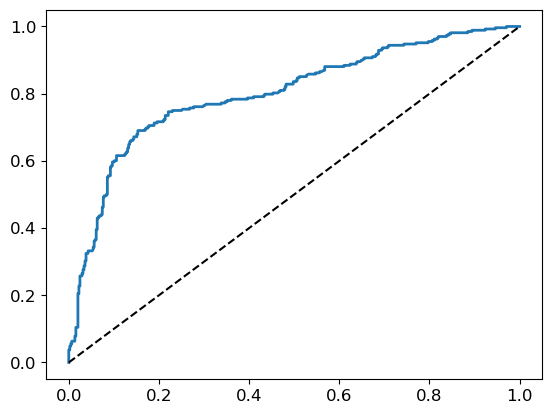

In [258]:
#This function handles drawing the ROC Curve graph
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()